# Holt-Winters Methods
En la clase anterior vimos los <strong> Promedios móviles ponderados exponencialmente </strong> (EWMA) que es un <em> Suavizado exponencial simple </em> usando un solo factor de suavizado $\alpha$ (alpha). Pero no tuvo en cuenta otros factores que contribuyen, como la tendencia y la estacionalidad.

En esta clase veremos el <em> Suavizado exponencial doble y triple </em> con los Métodos Holt-Winters. 

En el <strong> Suavizado exponencial doble </strong> (también conocido como Método de Holt) presentamos un nuevo factor de suavizado $\beta$ (beta) que aborda la tendencia:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    nivel}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    tendencia}\\
y_t &= l_t + b_t & \text{    modelo estimado}\\
\hat y_{t+h} &= l_t + hb_t & \text{    modelo de pronósticos (} h = \text{# periodos en el futuro)}\end{split}


Con <strong> Suavizado exponencial triple </strong> (también conocido como Método Holt-Winters) presentamos un factor de suavizado $\gamma$ (gamma) que aborda la estacionalidad:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    nivel}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    tendencia}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    estacionalidad}\\
y_t &= (l_t + b_t) c_t & \text{    modelo estimado}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    modelo de pronosticos (} m = \text{# periodos en el futuro)}\end{split}

Aquí $ L $ representa el número de divisiones por ciclo. En nuestro caso, mirando los datos mensuales que muestran un patrón repetitivo cada año, usaríamos $ L = 12 $.

En general, los valores más altos para $ \alpha $, $ \beta $ y $ \gamma $ (valores más cercanos a 1), ponen más énfasis en los datos recientes.

<div class="alert alert-info"><h3>Funciones:</h3>
<tt><strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html'>statsmodels.tsa.holtwinters.SimpleExpSmoothing</a></strong><font color=black></font>&nbsp;&nbsp;&nbsp;&nbsp;
Simple Exponential Smoothing<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>statsmodels.tsa.holtwinters.ExponentialSmoothing</a></strong><font color=black></font>&nbsp;&nbsp;
    Holt-Winters Exponential Smoothing</tt>
    

### Dataset de pasajeros de avión
Para estos ejemplos, continuaremos utilizando el conjunto de datos de Pasajeros de líneas aéreas internacionales, que proporciona totales mensuales en miles de personas desde enero de 1949 hasta diciembre de 1960.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/MaddoSaru/curso-series-temporales/master/3.%20Caracter%C3%ADsticas%20fundamentales/Python/airline_passengers.csv',index_col='Month',parse_dates=True)

In [3]:
df.dropna(inplace=True)

In [4]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [5]:
df.index.freq = 'MS'
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [6]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


___
## Suavizado exponencial simple

La función del suavizado exponencial simple de statsmodels realiza las mismas estimaciones que el método de promedios ponderados de pandas:


In [9]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha,adjust=False).mean()
df['SES12']=SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861


<div class = "alert alert-danger"> <strong> NOTA: </strong> por alguna razón, cuando <tt> optimized = False </tt> se pasa a <tt>.fit()</tt>, la función statsmodels <tt> SimpleExpSmoothing </tt> desplaza los valores ajustados una fila hacia abajo. Arreglamos esto agregando <tt>.shift(-1)</tt> después de <tt>.fittedvalues</tt> </div>

---
## Suavizado exponencial doble
Cuando el suavizado exponencial simple emplea solo un factor de suavizado $ \alpha $ (alpha), el suavizado exponencial doble agrega un segundo factor de suavizado $ \beta $ (beta) que aborda las tendencias en los datos. Al igual que el factor alpha, los valores para el factor beta están entre cero y uno ($ 0 <\beta≤1 $). El beneficio aquí es que el modelo puede anticipar futuros aumentos o disminuciones donde el modelo de un solo factor solo tendría en cuenta los valores más recientes.

También podemos abordar diferentes tipos de cambio (crecimiento / decadencia) en la tendencia. Si una serie temporal muestra una tendencia inclinada en línea recta, se usaría un ajuste <strong> aditivo </strong>. Si la serie temporal muestra una tendencia exponencial (curva), se usaría un ajuste <strong> multiplicativo </strong>.

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['DESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend = 'add').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12
Month,,,,
1949-01-01,112,112.000000,112.000000,114.336233
1949-02-01,118,112.923077,112.923077,120.336233
1949-03-01,132,115.857988,115.857988,134.336233
1949-04-01,129,117.879836,117.879836,131.336233
1949-05-01,121,118.359861,118.359861,123.336233


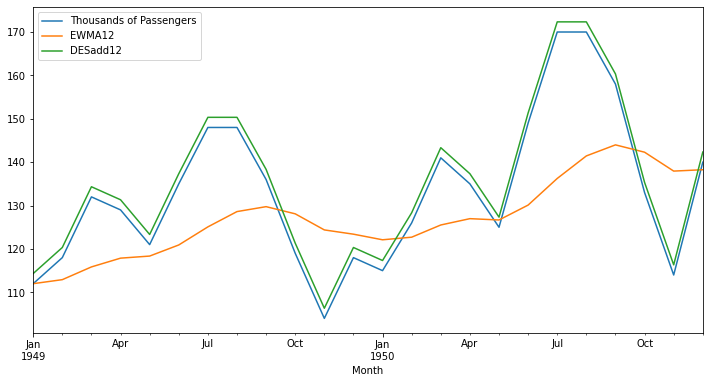

In [12]:
df[['Thousands of Passengers','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Aquí podemos ver que con el suavizado exponencial doble obtenemos una mejor representación de los datos. Veamos si usar un ajuste estacional multiplicativo ayuda.

In [ ]:
df['DESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12
Month,,,,,
1949-01-01,112,112.000000,112.000000,114.336233,112.049247
1949-02-01,118,112.923077,112.923077,120.336233,118.051885
1949-03-01,132,115.857988,115.857988,134.336233,132.058041
1949-04-01,129,117.879836,117.879836,131.336233,129.056722
1949-05-01,121,118.359861,118.359861,123.336233,121.053204


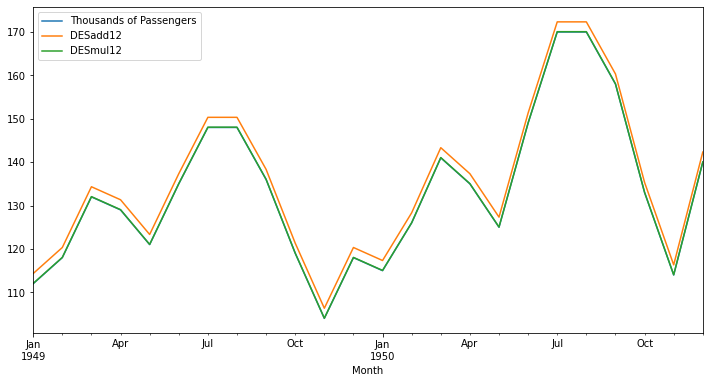

In [ ]:
df[['Thousands of Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6));

Aunque se obtienen valores un poco menores que los valores reales, parece que un ajuste multiplicativo da mejores resultados teniendo en cuenta que la línea verde se superpone casi por completo a los datos originales.

___
## Suavizado exponencial triple
Suavizado exponencial triple o Holt-Winters, añade soporte para la tendencia y la estacionalidad. 



In [13]:
df['TESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,Thousands of Passengers,EWMA12,SES12,DESadd12,TESadd12
Month,,,,,
1949-01-01,112,112.000000,112.000000,114.336233,113.081288
1949-02-01,118,112.923077,112.923077,120.336233,120.550747
1949-03-01,132,115.857988,115.857988,134.336233,135.527329
1949-04-01,129,117.879836,117.879836,131.336233,133.155064
1949-05-01,121,118.359861,118.359861,123.336233,125.656114


In [14]:
df['TESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,TESadd12,TESmul12
Month,,,,,,
1949-01-01,112,112.000000,112.000000,114.336233,113.081288,111.583236
1949-02-01,118,112.923077,112.923077,120.336233,120.550747,118.839294
1949-03-01,132,115.857988,115.857988,134.336233,135.527329,133.327416
1949-04-01,129,117.879836,117.879836,131.336233,133.155064,127.915388
1949-05-01,121,118.359861,118.359861,123.336233,125.656114,120.978320


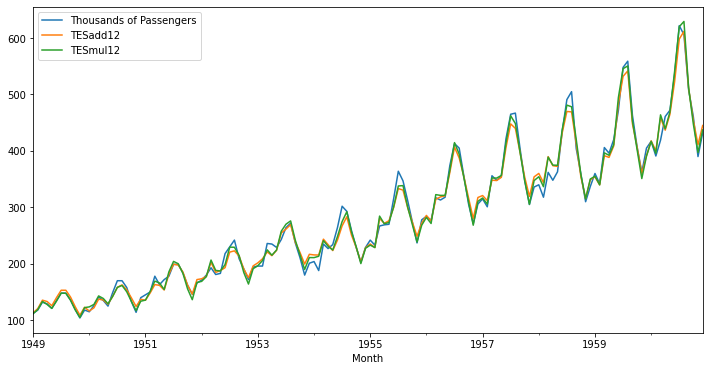

In [15]:
df[['Thousands of Passengers','TESadd12','TESmul12']].plot(figsize=(12,6));

In [16]:
model_add = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [17]:
model_mul = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [18]:
forecast_add = model_add.forecast(36)
forecast_mul= model_mul.forecast(36)

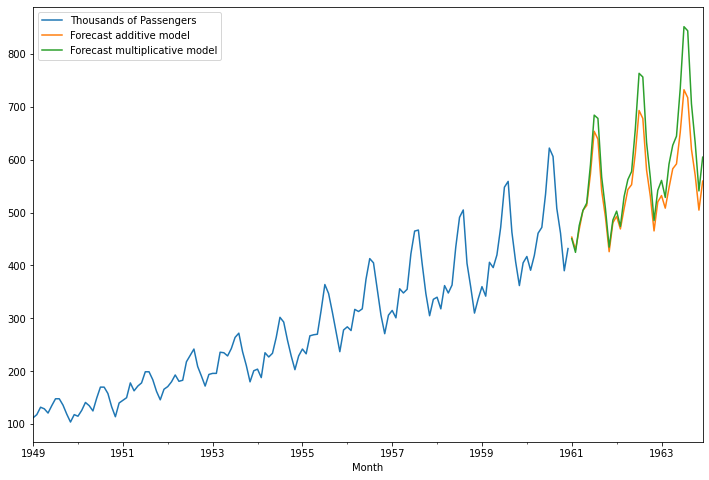

In [ ]:
import matplotlib.pyplot as plt

df['Thousands of Passengers'].plot(figsize=(12,8))
forecast_add.plot(label='Forecast additive model');
forecast_mul.plot(label='Forecast multiplicative model');
plt.legend(loc='upper left')